In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from torchvision import transforms
from torchvision.models import efficientnet_b2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from transformers import BertTokenizer
import os

In [2]:
dir_path="/kaggle/input/multi-label-classification-competition-2025/COMP5329S1A2Dataset/"
train_file_name="train.csv"
test_file_name ="test.csv"
train_csv = pd.read_csv(os.path.join(dir_path,train_file_name),usecols=[0,1,2])
test_csv = pd.read_csv(os.path.join(dir_path,test_file_name),usecols=[0,1])

In [3]:
all_label_lists = train_csv['Labels'].apply(lambda x: list(map(int, x.split())))
flat_labels = [label for sublist in all_label_lists for label in sublist]
num_classes = max(flat_labels) + 1
def multilable_to_onehot(label_str,num_classes):
    labels=list(map(int,label_str.split()))
    onehot= np.zeros(num_classes,dtype=np.float32)
    onehot[labels]=1
    return onehot
train_csv["onehot"]= train_csv['Labels'].apply(lambda x: multilable_to_onehot(x,num_classes))
train_csv

,ImageID,Labels,Caption,onehot
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2.jpg,1,They are brave for riding in the jungle on tho...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
...,...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29997,29997.jpg,1,A man riding a snowboard on top of snow.,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29998,29998.jpg,1,This photo shows people skiing in the mountains.,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Pre-processing

Number of Training data: 30000
Labels
1             14075
17              975
1 15            876
1 3             740
16              673
              ...  
3 13 7            1
1 19 14           1
1 3 6 8 16        1
1 18 7            1
1 2 3 4 9         1
Name: count, Length: 777, dtype: int64


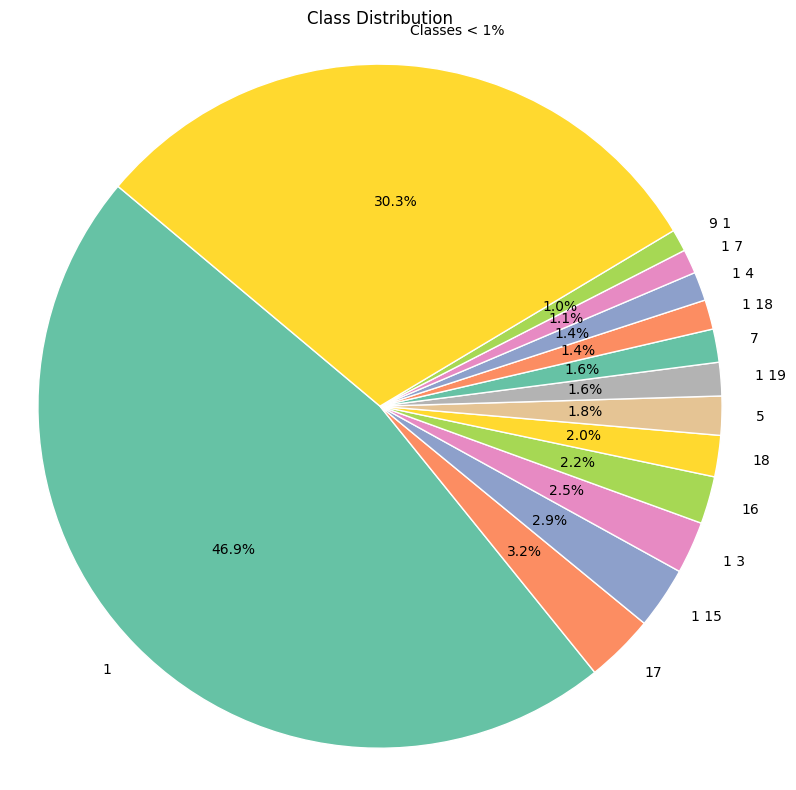

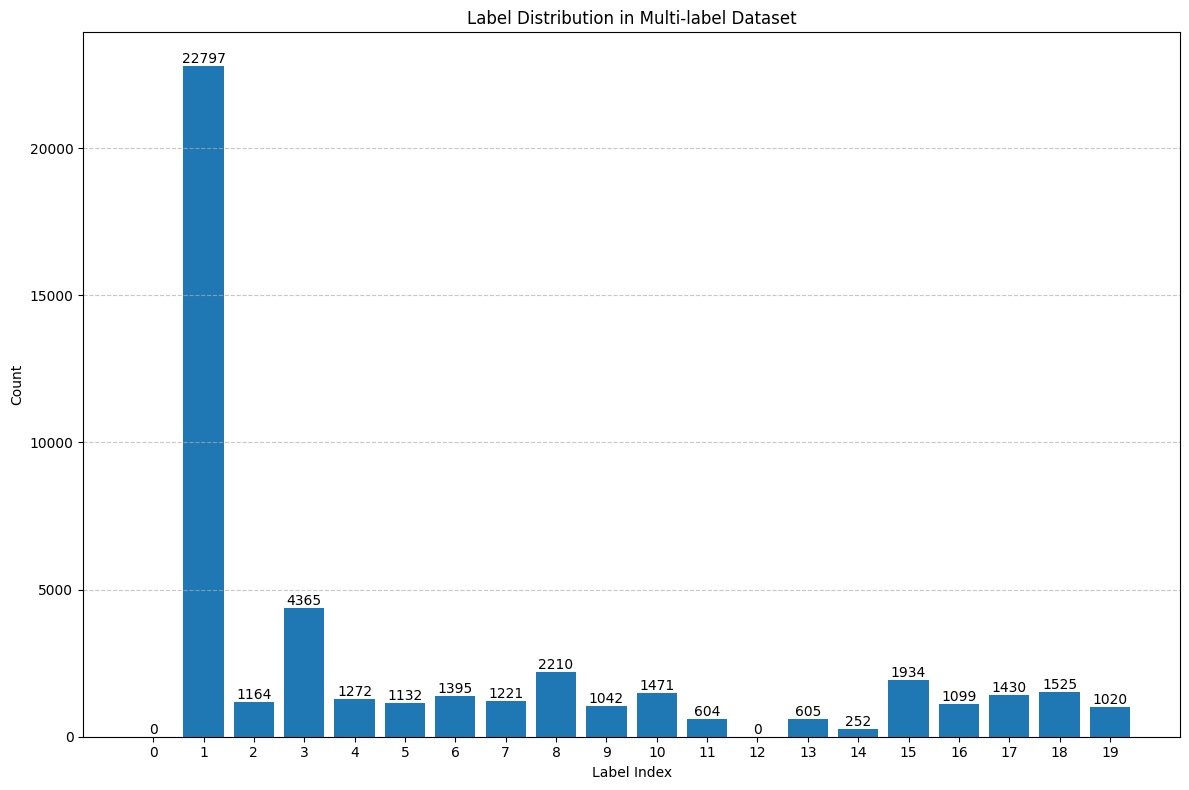

In [4]:
print("Number of Training data:",train_csv.shape[0])
class_counts=train_csv['Labels'].value_counts()
print(class_counts)
# classify different labels
small_classes = class_counts[class_counts < 0.01 * class_counts.sum()]
other_count = small_classes.sum()
class_counts = class_counts[class_counts >= 0.01 * class_counts.sum()]
class_counts['Classes < 1%'] = other_count

# Plot pie chart
colors = sns.color_palette("Set2", n_colors=len(class_counts))

# 画饼图
plt.figure(figsize=(8, 8))
plt.pie(
    class_counts.values,
    labels=class_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Class Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()


#plot bar chart
label_counts=train_csv['onehot'].sum(axis=0)
plt.figure(figsize=(12,8))
bars=plt.bar(range(len(label_counts)),label_counts)
for i, count in enumerate(label_counts):
    plt.text(i,count+0.5, str(int(count)), ha='center', va='bottom')

plt.xlabel("Label Index")
plt.ylabel("Count")
plt.title("Label Distribution in Multi-label Dataset")
plt.xticks(range(len(label_counts))) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
#we have 30k images, which is big enough, just do some kind of augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
class ass2Dataset(Dataset):
    def __init__(self,df,image_dir,transform=None,tokenizer=None,max_length=128):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image_path=f"{self.image_dir}/{self.df.iloc[idx]['ImageID']}"
        image=Image.open(image_path).convert("RGB")
        if self.transform:
            image=self.transform(image)
        text=self.df.iloc[idx]['Caption']
        encoded_text = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_kength,
            return_tensor="pt"
        )
        input_ids = encoded_text['input_ids'].squeeze(0)
        attention_mask = encoded_text['attention_mask'].squeeze(0)

        labels = self.df.iloc[idx]['onehot'] 
        labels = torch.tensor(labels).float() 
        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": labels
        }
# train_dataset = ass2Dataset(train_csv, image_dir="data/", transform=train_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [7]:
import torch.nn.functional as F
alpha=1.0/(label_counts+1e-6)
alpha=alpha/alpha.sum()
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, bce_weight=0.5):
        super(BCEFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')        
        pt=torch.exp(-bce_loss)
        if self.alpha is not None:
            alpha=self.alpha.to(inputs.device)
            bce_loss=bce_loss*alpha
            focal_loss=focal_loss*alpha
        loss=self.bce_weight*bce_loss.mean()+ (1 - self.bce_weight) * focal_loss.mean()
        return loss

criterion = BCEFocalLoss(alpha=alpha, gamma=2, bce_weight=0.5)

## Model

In [17]:
class MultiModalClassifier(nn.Module):
    def __init__(self,num_labels=20,resnet_out=512,bert_out=768,dropout=0.3):
        super(MultiModalClassifier,self).__init__()
        self.resnet50 = resnet50(pretrained=True)
        self.resnet.fc=nn.Linear(self.resnet.fc.in_features,resnet_out)
        self.bert=BertModel.from_pretrained("bert-base-uncased")
        self.text_fc=nn.Linear(bert_out,bert_out)
        self.classifier=nn.Sequential(
            nn.Linear(resnet_out + bert_out,512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512,num_labels)
        )
    def forward(self,image,input_ids,attention_mask):
        image_features=self.resnet(image)
        bert_output=self.bert(input_ids=input_ids,attention_mask=attention_mask)
        text_features=self.text_fc(bert_output.pooler_output)
        fused=torch.cat((image_features,text_features),dim=1)
        logits=self.classifier(fused)
        return logits

In [11]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        images, input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            images, input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(images, input_ids, attention_mask)
            preds = torch.sigmoid(outputs) > threshold

            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    micro_f1 = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    macro_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    return micro_f1, macro_f1


In [19]:
from torchvision.models import resnet50

def main():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    train_df = train_csv.sample(frac=0.8, random_state=42)
    val_df = train_csv.drop(train_df.index)

    train_dataset = ass2Dataset(train_df, "./data", tokenizer, train_transform)
    val_dataset = ass2Dataset(val_df, "./data", tokenizer, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    model = MultiModalClassifier().cuda()

    # 根据标签频率初始化 alpha
    label_freq = torch.tensor(df["onehot"].tolist()).sum(dim=0)
    alpha = 1.0 / (label_freq + 1e-6)
    alpha = alpha / alpha.sum()

    criterion = BCEFocalLoss(alpha=alpha, gamma=2, bce_weight=0.5)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(10):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda')
        micro_f1, macro_f1 = evaluate(model, val_loader, device='cuda')

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Micro-F1: {micro_f1:.4f} | Macro-F1: {macro_f1:.4f}")
if __name__ == '__main__':
    main()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s] 


AttributeError: 'MultiModalClassifier' object has no attribute 'resnet'